## Imports

In [63]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import json
import pathlib
import re
import pandas as pd
import numpy as np
import torch
from matplotlib import cm
from scipy.io import wavfile
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import _datasets as D
import _models as M

EPS = 1e-8

# select device
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda:0'

mean_vector_paths = list(pathlib.Path('weights_sv').rglob('mean_vectors.npy'))
checkpoint_paths = list(pathlib.Path('weights_sv').rglob('checkpoint'))

## Generate speaker-mean vectors per checkpoint

In [10]:
if len(mean_vector_paths) < len(checkpoint_paths):
    with torch.no_grad():
        for checkpoint_path in checkpoint_paths:

            hidden_size = int(re.search(r'hidden_size=(\d+)', str(checkpoint_path))[1])

            # instantiate network
            network = M.NetSV(hidden_size=hidden_size, num_layers=2).to(device)
            sd = torch.load(checkpoint_path, map_location=torch.device(device))
            network.load_state_dict(sd)

            # loop through each speaker
            mean_vectors = {}
            for speaker_id in D.speaker_ids_tr:
                df = D.librispeech.query(f'speaker_id == "{speaker_id}"')
                vectors = []
                for filepath in df.filepath:
                    (_, s) = wavfile.read(filepath)
                    s = s / np.abs(s).max()
                    s = torch.Tensor(s).unsqueeze(0).to(device)
                    features = network.embedding(s).squeeze()
                    vectors.append(features)
                vectors = torch.stack(vectors)
                mean_vectors[speaker_id] = torch.mean(vectors, dim=0).cpu().numpy()

            np.save(str(checkpoint_path.with_name('mean_vectors.npy')), mean_vectors)

            print('Finished', str(checkpoint_path.with_name('mean_vectors.npy')))

## Mean vectors gender clustering, TSNE for visualization 

hidden_size=32,utterance_duration=5_2021-04-16_01-34-12/checkpoint_4540/mean_vectors.npy


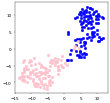

hidden_size=64,utterance_duration=5_2021-04-16_01-34-12/checkpoint_2710/mean_vectors.npy


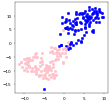

hidden_size=96,utterance_duration=5_2021-04-16_01-34-12/checkpoint_3060/mean_vectors.npy


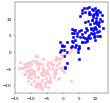

In [72]:
figsize = (4, 4)
dpi = 30
num_plots = 3

for mean_vector_path in sorted(mean_vector_paths)[:num_plots]:
    print('hidden'+str(mean_vector_path).split('hidden')[1])
    df = np.load(mean_vector_path, allow_pickle=True).item()
    data = np.vstack(list(df.values()))
    labels = np.vstack(list(df.keys())).squeeze()

    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, random_state=0)
    data_2d = tsne.fit_transform(data)

    fig = plt.figure(figsize=figsize, dpi=dpi)
        
    # plot by gender
    colors = {'M': 'blue', 'F': 'pink'}
    for i in range(0, len(labels), 1):
        speaker_id = labels[i]
        gender = D.speakers_tr[D.speakers_tr.speaker_id==speaker_id].gender.item()
        plt.scatter(data_2d[i, 0], data_2d[i, 1], c=colors[gender])

    # annotate with the speaker IDs
    if False:
        for i in range(0, len(labels), 1):
            plt.annotate(xy=(data_2d[i, 0], data_2d[i, 1]), text=labels[i])

    plt.show()

## Mean vectors K-Means clustering, TSNE for visualization

hidden_size=32,utterance_duration=5_2021-04-16_01-34-12/checkpoint_4540/mean_vectors.npy


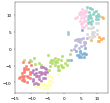

hidden_size=64,utterance_duration=5_2021-04-16_01-34-12/checkpoint_2710/mean_vectors.npy


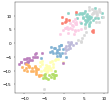

hidden_size=96,utterance_duration=5_2021-04-16_01-34-12/checkpoint_3060/mean_vectors.npy


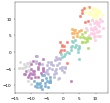

hidden_size=32,utterance_duration=3_2021-04-16_01-34-12/checkpoint_4030/mean_vectors.npy


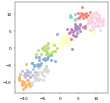

hidden_size=64,utterance_duration=3_2021-04-16_01-34-12/checkpoint_3230/mean_vectors.npy


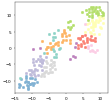

hidden_size=96,utterance_duration=3_2021-04-16_01-34-12/checkpoint_4330/mean_vectors.npy


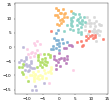

hidden_size=32,utterance_duration=1_2021-04-16_01-34-12/checkpoint_2990/mean_vectors.npy


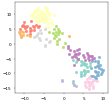

hidden_size=64,utterance_duration=1_2021-04-16_01-34-12/checkpoint_2590/mean_vectors.npy


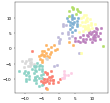

hidden_size=96,utterance_duration=1_2021-04-16_01-34-12/checkpoint_3600/mean_vectors.npy


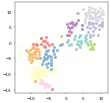

In [71]:
figsize = (4, 4)
dpi = 30
num_plots = 10

for mean_vector_path in sorted(mean_vector_paths)[:num_plots]:
    print('hidden'+str(mean_vector_path).split('hidden')[1])
    df = np.load(mean_vector_path, allow_pickle=True).item()
    data = np.vstack(list(df.values()))
    labels = np.vstack(list(df.keys())).squeeze()

    kmeans = KMeans(n_clusters=10, random_state=0).fit(data)
    classes = kmeans.labels_
    mapping = {k:int(v) for (k,v) in zip(labels, classes)}
    
    with open(str(mean_vector_path.with_name('map_speaker_to_specialist.json')), 'w') as fp:
        json.dump(mapping, fp, sort_keys=True, indent=2)
    
    def reverse_non_unique_mapping(d):
        dinv = {}
        for k, v in d.items():
            v = int(v)
            if v in dinv:
                dinv[v].append(k)
            else:
                dinv[v] = [k]
        return dinv
    
    mapping = reverse_non_unique_mapping(mapping)

    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, random_state=0)
    data_2d = tsne.fit_transform(data)
    
    with open(str(mean_vector_path.with_name('map_specialist_to_speakers.json')), 'w') as fp:
        json.dump(mapping, fp, sort_keys=True, indent=2)

    fig = plt.figure(figsize=figsize, dpi=dpi)
        
    # plot by k-means
    if True:
        for i in range(0, len(labels), 1):
            colors = cm.get_cmap("Set3").colors
            plt.scatter(data_2d[i, 0], data_2d[i, 1], color=colors[classes[i]])
    
    # plot by gender
    colors = {'M': 'blue', 'F': 'pink'}
    if False:
        for i in range(0, len(labels), 1):
            speaker_id = labels[i]
            gender = D.speakers_tr[D.speakers_tr.speaker_id==speaker_id].gender.item()
            plt.scatter(data_2d[i, 0], data_2d[i, 1], c=colors[gender])

    # annotate with the speaker IDs
    if False:
        for i in range(0, len(labels), 1):
            plt.annotate(xy=(data_2d[i, 0], data_2d[i, 1]), text=labels[i])

    plt.show()